In [160]:
import os, sys
import pandas as pd
import pickle
from os.path import dirname, abspath
d = os.path.abspath(os.path.join('..'))
sys.path.append(d)
from model_trial import Experiment
from util.file_processor import FileProcessor
from sklearn.metrics import mean_absolute_error
from sklearn import tree
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize' : [1.0*3.125, 1.5*0.8],
                           'legend.fontsize': 10, 'legend.fancybox': True,
                           'font.family': 'serif', 'font.sans-serif': 'Times',
                            'xtick.major.width': 0.2, 'xtick.minor.width': 2*0.2,
                            'ytick.major.width': 0.2, 'ytick.minor.width': 2*0.2,
                            'text.usetex': False, 'axes.labelsize': 7*2,
                            'axes.spines.right': False, 'axes.spines.top': False
                           })
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import numpy as np
import re
import graphviz
import pathlib
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [93]:
%run '../util/webrtc_reader.py'
%run '../util/helper_functions.py'

In [94]:
datasets = ['th', 'th_jitter', 'lat', 'lat_jitter', 'loss']
data_dir = '/home/taveesh/Documents/Projects/vca-qoe-inference/data'
cross_validations = 1
tested_vcas = ['meet', 'teams', 'webex']
traces_available = False
timestamps_available = False
metrics = ['framesReceivedPerSecond']

In [95]:
model_name_lookup = {
        'IP/UDP ML': '{}_ml_random_LSTATS-TSTATS_rf_full_video_{}_cv_{}_original',
        'IP/UDP Heuristic': '{}_frame-lookback_random_LSTATS-TSTATS_rf_full_video_{}_cv_{}_original',
        'RTP ML': '{}_rtp_ml_random_LSTATS-TSTATS_rf_full_video_{}_cv_{}_original',
        'RTP Heuristic': '{}_rtp_random_LSTATS-TSTATS_rf_full_video_{}_cv_{}_original'
}

col_map = {
        '{}_{}': 'Prediction',
        '{}_gt': 'Ground Truth',
        'throughput_mean_kbps': 'Throughput Mean (Kbps)',
        'throughput_std_kbps': 'Throughput Jitter (Kbps)',
        'latency_mean_ms': 'Latency Mean (ms)',
        'latency_std_ms': 'Latency Jitter (ms)',
        'MAE': 'Mean Absolute Error'
}
feature_map = {
    'l_mean': 'Packet size mean', 'l_std': 'Packet size standard deviation', 'l_min': 'Packet size min', 'l_max': 'Packet size max', 'l_q1': 'Packet size 25th percentile',
    'l_q2': 'Packet size 50th percentile', 'l_q3': 'Packet size 75th percentile', 'l_num_pkts': 'Total number of packets', 'l_num_bytes': 'Total number of bytes', 
    'l_num_unique': 'Total number of unique packet sizes', 'l_num_rtx': 'Number of packet retransmissions','t_mean': 'Packet IAT mean', 
    't_std': 'Packet IAT standard deviation', 't_min': 'Packet IAT min', 't_max': 'Packet IAT max', 't_q1': 'Packet IAT 25th percentile',
    't_q2': 'Packet IAT 50th percentile', 't_q3': 'Packet IAT 75th percentile', 't_burst_count': 'Burst Count',
    't_num_pkts': 'Total number of packets', 't_et': 'Interval end time', 'num_rtx': 'Number of retransmissions',
    'vid_ts_unique': 'Number of unique RTP video timestamps', 'rtx_ts_unique': 'Number of unique RTP retransmission timestamps', 'vid_marker_sum': 'Marker bit sum for video packets', 'rtx_marker_sum': 'Marker bit sum for retransmitted packets',
    'common_vid_rtx_ts_unique': 'Number of unique RTP timestamps shared by video and RTx streams', 'ooo_seqno_vid': 'Number of out of order video sequence numbers', 'buffer_time_mean': 'Mean of expected frame playback time', 'buffer_time_std': 'Stdev of expected frame playback time' , 'buffer_time_min': 'Min of expected frame playback time', 'buffer_time_max': 'Max of expected frame playback time', 'buffer_time_q1': 'Q1 of expected frame playback time', 'buffer_time_q2': 'Q2 of expected frame playback time', 'buffer_time_q3': 'Q3 of expected frame playback time', 'n_pkt_diff_mean': 'Mean number of packets between first and last packet of a frame',  'n_pkt_diff_std': 'Stdev of number of packets between first and last packet of a frame',
    'n_pkt_diff_min': 'Min number of packets between first and last packet of a frame','n_pkt_diff_max': 'Max number of packets between first and last packet of a frame','n_pkt_diff_q1': 'Q1 of number of packets between first and last packet of a frame','n_pkt_diff_q2': 'Q2 of number of packets between first and last packet of a frame','n_pkt_diff_q3': 'Q3 of number of packets between first and last packet of a frame', 'rtp_lag_min': 'Min expected playback time lag','rtp_lag_max':'Max expected playback time lag',
    'rtp_lag_q1': 'Q1 of expected playback time lag','rtp_lag_q2': 'Playback time lag 50th percentile','rtp_lag_q3': 'Q3 of expected playback time lag','rtp_lag_mean': 'Mean expected playback time lag','rtp_lag_std': 'Stdev of expected playback time lag'
}
suffix_map = {
    'IP/UDP ML': 'ml',
    'IP/UDP Heuristic': 'frame-lookback',
    'RTP ML': 'rtp_ml',
    'RTP Heuristic': 'rtp'
}

In [96]:
def load_pkl(path):
    with open(path, 'rb') as fd:
        obj = pickle.load(fd)
    return obj

def get_call_logs(cv, vca, dataset):
    pref = data_dir+'/'+dataset+'_cv_splits'
    spl = load_pkl(pref + '/' +'cv_file_splits.pkl')
    cols=['pcap_file', 'csv_file', 'webrtc_file']
    if traces_available:
        cols += ['trace_file']
    if timestamps_available:
        cols += ['timestamp_file']
    df = pd.DataFrame(spl[cv-1][vca]['test'], columns=cols)
    return df

def load_intermediates(method):
    suffix = f'_{suffix_map[method]}'
    preds = []
    f_imp = {}
    for metric in metrics:
        for dataset in datasets:
            print('Metric:', metric)
            f_imp[metric] = {}
            if metric == 'frameHeight' and 'Heuristic' in method:
                continue
            for cv in range(1, cross_validations+1):
                pref = model_name_lookup[method].format(metric, dataset, cv) + '/' + model_name_lookup[method].format(metric, dataset, cv)
                experiment = pref+'.pkl'
                model = pref+'_vca_model.pkl'
                predictions = pref+'_predictions.pkl'
                ddir = data_dir + '/' + dataset
                exp = load_pkl(ddir+'_intermediates/'+experiment)
                mod = load_pkl(ddir+'_intermediates/'+model)
                pred = load_pkl(ddir+'_intermediates/'+predictions)
                f_imp[metric][cv] = {}
                for vca in tested_vcas:
                    df_logs = get_call_logs(cv, vca, dataset)
                    f_imp[metric][cv][vca] = (mod[vca].feature_importances if 'ML' in method else None)
                    for df in pred[vca]:
                        if df is None:
                            continue
                        pcap = df['file'].unique()[0]
                        dfl = df_logs[df_logs['pcap_file'] == pcap]
                        rdr = WebRTCReader(dfl['webrtc_file'].unique()[0], dataset)
                        df_webrtc = rdr.get_webrtc()
                        df['cross_val'] = cv
                        df['metric'] = metric
                        df['method'] = method
                        df['VCA'] = vca
                        df[f'deviation'] = df[metric+suffix] - df[f'{metric}_gt']
                        df[f'abs_deviation'] = abs(df['deviation'])
                        df_merged = pd.merge(df, df_webrtc, left_on='timestamp', right_on='ts')
                        df_merged['csv_file'] = dfl['csv_file'].unique()[0]
                        df_merged['webrtc_file'] = dfl['webrtc_file'].unique()[0]
                        if traces_available:
                            df_merged['trace_file'] = dfl['trace_file'].unique()[0]
                        if timestamps_available:
                            df_merged['timestamp_file'] = dfl['timestamp_file'].unique()[0]
                        # df_merged['trace_profile'] = '-'.join(os.path.basename(dfl['csv_file'].unique()[0])[:-4].split('-')[2:8])
                        df_merged = df_merged.rename(columns={'file': 'pcap_file', metric+suffix: 'Prediction', f'{metric}_gt': 'Ground Truth'})
                        preds.append(df_merged)
    df = pd.concat(preds, axis=0)
    return df, f_imp

In [97]:
rtp_ml, f_rtp_ml = load_intermediates('RTP ML')

Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond


In [98]:
udp_ml, f_udp_ml = load_intermediates('IP/UDP ML')

Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond


In [328]:
rtp_non_ml, f_rtp_non_ml = load_intermediates('RTP Heuristic')

Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond


In [336]:
udp_non_ml, f_udp_non_ml = load_intermediates('IP/UDP Heuristic')

Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond


In [337]:
df = pd.concat([rtp_ml, udp_ml, rtp_non_ml, udp_non_ml], axis=0)

In [338]:
df.to_csv('imc_lab_results_net_conditions.csv', index=False)

# Overall Numbers

In [332]:
df = pd.read_csv('imc_lab_results_net_conditions.csv', index_col=None)

/home/taveesh/Documents/Projects/vca-qoe-inference/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3194: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [104]:
# df.loc[df['metric'] == 'bitrate', 'abs_deviation'] /= 1000
print('IP/UDP ML')
df_fps = df[(df['metric'] == 'framesReceivedPerSecond') & (df['method'] == 'IP/UDP ML')]
dfg = df_fps.groupby(['VCA', 'dataset'])['abs_deviation'].mean()
print(dfg.to_latex(float_format="%.2f"))

# df.loc[df['metric'] == 'bitrate', 'abs_deviation'] /= 1000
print('RTP ML')
df_fps = df[(df['metric'] == 'framesReceivedPerSecond') & (df['method'] == 'RTP ML')]
dfg = df_fps.groupby(['VCA', 'dataset'])['abs_deviation'].mean()
print(dfg.to_latex(float_format="%.2f"))
dfg.reset_index()
# df_fps = df[df['metric'] == 'bitrate']
# dfg = df_fps.groupby(['method', 'VCA'])['abs_deviation'].mean()
# print('Bitrate')
# print(dfg.to_latex(float_format="%.2f"))
# df_fps = df[df['metric'] == 'frame_jitter']
# dfg = df_fps.groupby(['method', 'VCA'])['abs_deviation'].mean()
# print('Frame Jitter')
# print(dfg.to_latex(float_format="%.2f"))

IP/UDP ML
\begin{tabular}{llr}
\toprule
      &           &  abs\_deviation \\
VCA & dataset &                \\
\midrule
meet & lat &           2.09 \\
      & lat\_jitter &           2.19 \\
      & loss &           3.68 \\
      & th &           1.27 \\
      & th\_jitter &           1.67 \\
teams & lat &           2.51 \\
      & lat\_jitter &           2.05 \\
      & loss &           6.64 \\
      & th &           1.56 \\
      & th\_jitter &           2.28 \\
webex & lat &           0.63 \\
      & lat\_jitter &           1.40 \\
      & loss &           2.01 \\
      & th &           1.45 \\
      & th\_jitter &           2.60 \\
\bottomrule
\end{tabular}

RTP ML
\begin{tabular}{llr}
\toprule
      &           &  abs\_deviation \\
VCA & dataset &                \\
\midrule
meet & lat &           1.34 \\
      & lat\_jitter &           1.56 \\
      & loss &           2.52 \\
      & th &           1.14 \\
      & th\_jitter &           1.55 \\
teams & lat &           2.38 \\
  

,VCA,dataset,abs_deviation
0,meet,lat,1.34
1,meet,lat_jitter,1.56
2,meet,loss,2.52
3,meet,th,1.14
4,meet,th_jitter,1.55
5,teams,lat,2.38
6,teams,lat_jitter,2.06
7,teams,loss,5.51
8,teams,th,1.71
9,teams,th_jitter,2.35


In [105]:
df1 = df[(df['method'] == 'IP/UDP ML') & (df['dataset'] == 'th')]
df2 = df[(df['method'] == 'IP/UDP ML') & (df['dataset'] == 'th_jitter')]
df3 = df[(df['method'] == 'IP/UDP ML') & (df['dataset'] == 'lat')]
df4 = df[(df['method'] == 'IP/UDP ML') & (df['dataset'] == 'lat_jitter')]
df5 = df[(df['method'] == 'IP/UDP ML') & (df['dataset'] == 'loss')]

In [342]:
labels = {'th': 'Mean Throughput [kbps]', 'th_jitter': 'Throughput stdev. [kbps]', 
         'lat': 'Mean Delay [ms]', 'lat_jitter': 'Delay stdev [ms]', 'loss': 'Packet Loss [%]'}

def get_net_params(csv_file):
    fname = os.path.basename(csv_file)[:-4]
    fname = fname.split('-')[-2]
    t = tuple(map(int, fname.split('_')))[:-1]
    return t

def get_boxplot(d, param):
    d_ = d[d['dataset'] == param]
    d_['VCA'] = d_['VCA'].replace({'meet': 'Meet', 'teams': 'Teams', 'webex': 'Webex'})
    d_['th'], d_['th_jitter'], d_['lat'], d_['lat_jitter'], d_['loss'] =  zip(*d_['csv_file'].map(get_net_params))
    plt.figure(figsize=(4, 2))
    plt.rcParams["figure.autolayout"] = True
    ax = sns.boxplot(d_, x = param, y = 'deviation', hue='VCA', whis=[10, 90], showfliers=False)
    plt.ylabel('FPS Error', fontsize=10)
    plt.xlabel(labels[param], fontsize=10)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False, prop={'size': 8})
    plt.grid()
    plt.savefig(f'paper_plots/{param}_box_sensitivity.pdf', bbox_inches='tight')
    
def get_plot(d, param, method):
    d_ = d[d['dataset'] == param]
    d_['VCA'] = d_['VCA'].replace({'meet': 'Meet', 'teams': 'Teams', 'webex': 'Webex'})
    d_['th'], d_['th_jitter'], d_['lat'], d_['lat_jitter'], d_['loss'] =  zip(*d_['csv_file'].map(get_net_params))
    plt.figure(figsize=(4, 2))
    plt.rcParams["figure.autolayout"] = True
    ax = sns.lineplot(d_, x = param, y = 'abs_deviation', hue='VCA', marker='o', estimator='mean', errorbar='ci')
    plt.setp(ax.get_xticklabels(), rotation=-1, ha="left")
    plt.ylabel('MAE', fontsize=10)
    plt.xlabel(labels[param], fontsize=10)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False, prop={'size': 8})
    if param == 'th':
        ticks = [100, 500, 1000, 2000, 4000]
    elif param == 'th_jitter':
        ticks = [0, 100, 500, 1000, 1500]
    elif param == 'lat':
        ticks = [50, 100, 200, 300, 400, 500]
    elif param == 'lat_jitter':
        ticks = range(10, 110, 10)
    elif param == 'loss':
        ticks = [1,2,5,10,20]
    plt.ylim([0, 10])
    plt.xticks(ticks)
    plt.grid()
    plt.savefig(f'paper_plots/{param}_{method}_line_sensitivity.pdf', bbox_inches='tight')

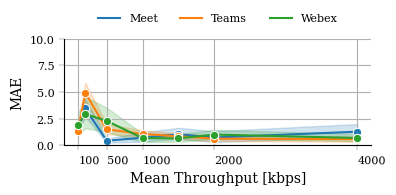

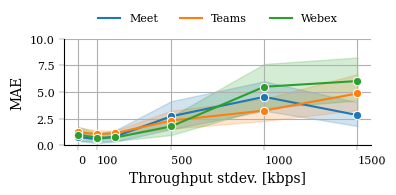

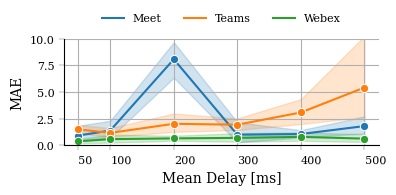

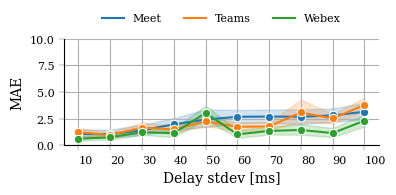

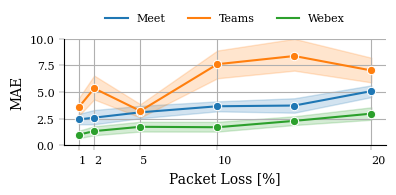

In [343]:
d = df[df['method'] == 'IP/UDP ML']
get_plot(d, 'th', 'ipml')
get_plot(d, 'th_jitter', 'ipml')
get_plot(d, 'lat', 'ipml')
get_plot(d, 'lat_jitter', 'ipml')
get_plot(d, 'loss', 'ipml')

# get_boxplot(d, 'th')
# get_boxplot(d, 'th_jitter')
# get_boxplot(d, 'lat')
# get_boxplot(d, 'lat_jitter')
# get_boxplot(d, 'loss')

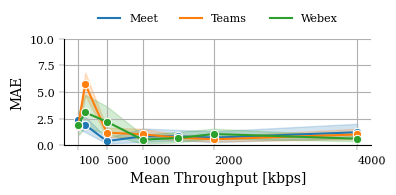

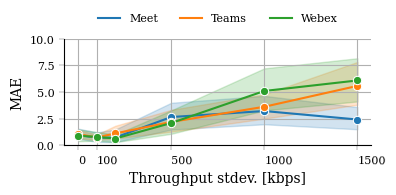

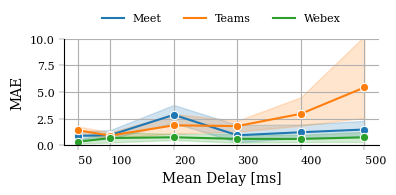

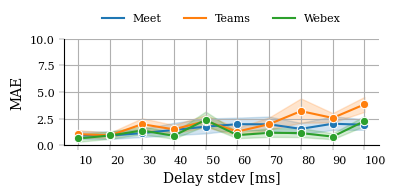

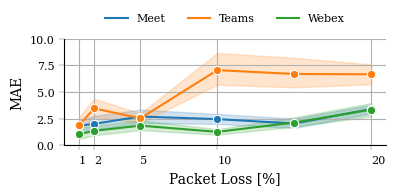

In [344]:
d = df[df['method'] == 'RTP ML']
get_plot(d, 'th', 'rtpml')
get_plot(d, 'th_jitter', 'rtpml')
get_plot(d, 'lat', 'rtpml')
get_plot(d, 'lat_jitter', 'rtpml')
get_plot(d, 'loss', 'rtpml')

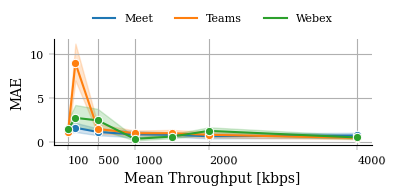

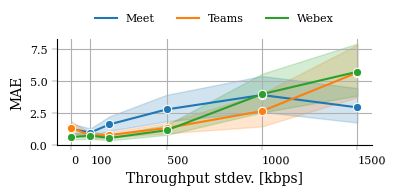

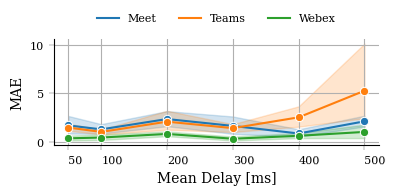

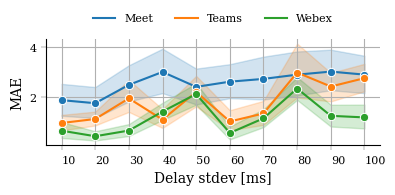

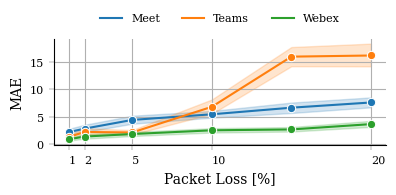

In [333]:
d = df[df['method'] == 'RTP Heuristic']
get_plot(d, 'th')
get_plot(d, 'th_jitter')
get_plot(d, 'lat')
get_plot(d, 'lat_jitter')
get_plot(d, 'loss')

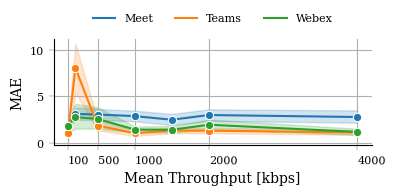

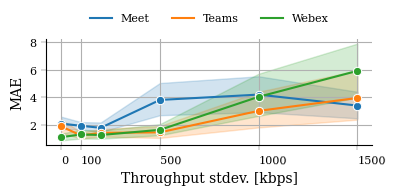

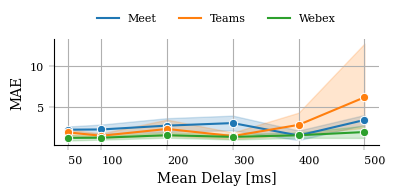

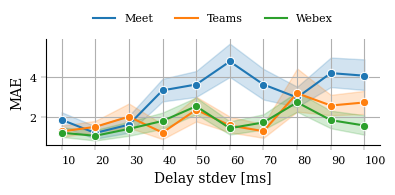

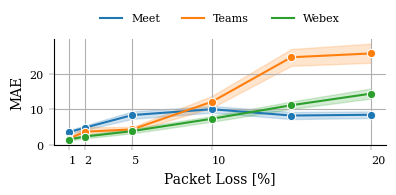

In [339]:
d = df[df['method'] == 'IP/UDP Heuristic']
get_plot(d, 'th')
get_plot(d, 'th_jitter')
get_plot(d, 'lat')
get_plot(d, 'lat_jitter')
get_plot(d, 'loss')

In [910]:
dfb = df[df['metric'] == 'bitrate']
dfb['Ground Truth'] /= 1000
dfb.groupby('VCA')['Ground Truth'].median()

VCA
meet    128.18
teams   527.57
webex   530.83
Name: Ground Truth, dtype: float64

# Deviations Across methods

In [1029]:
import random
colors = sns.hls_palette(24, l=0.5, s=1).as_hex()
random.shuffle(colors)

In [1033]:
colors[0], colors[5] = colors[5], colors[0]
colors

['#0070ff',
 '#ff0070',
 '#00ff0f',
 '#ffcf00',
 '#b0ff00',
 '#00b0ff',
 '#70ff00',
 '#ff0030',
 '#00ff8f',
 '#ff4f00',
 '#ff00b0',
 '#8f00ff',
 '#00ffcf',
 '#ff0f00',
 '#30ff00',
 '#00ff4f',
 '#cf00ff',
 '#00f0ff',
 '#f0ff00',
 '#ff00f0',
 '#4f00ff',
 '#0f00ff',
 '#ff8f00',
 '#0030ff']

In [1097]:
list(colors)

['#0070ff',
 '#ff0070',
 '#00ff0f',
 '#ffcf00',
 '#b0ff00',
 '#00b0ff',
 '#70ff00',
 '#ff0030',
 '#00ff8f',
 '#ff4f00',
 '#ff00b0',
 '#8f00ff',
 '#00ffcf',
 '#ff0f00',
 '#30ff00',
 '#00ff4f',
 '#cf00ff',
 '#00f0ff',
 '#f0ff00',
 '#ff00f0',
 '#4f00ff',
 '#0f00ff',
 '#ff8f00',
 '#0030ff']

In [1034]:
def plot_fps(df_fps, vca):
    labels = []
    meet = df_fps[df_fps['VCA'] == vca]
    llabels = {}
    for txt in suffix_map.keys():
        d = meet[meet['Method'] == txt]
        mae = round(mean_absolute_error(d['Prediction'], d['Ground Truth']), 2)
        d['Method'] = d['Method'].map({txt: txt + f"; MAE = {mae}"})
        labels.append(d)
        llabels[txt] =  txt + f"; MAE = {mae}"
    meet = pd.concat(labels, axis=0)
    fig, ax = plt.subplots(1, 1)
    sns.ecdfplot(meet[meet['Method'].str.contains('RTP ML')], x = 'deviation', ls=None, color=colors[0], ax=ax, label=llabels['RTP ML'])
    sns.ecdfplot(meet[meet['Method'].str.contains('IP/UDP ML')], x = 'deviation', ls=None, color=colors[1], ax=ax, label=llabels['IP/UDP ML'])
    sns.ecdfplot(meet[meet['Method'].str.contains('RTP Heuristic')], x = 'deviation', ls='--', color=colors[0], ax=ax, label=llabels['RTP Heuristic'])
    sns.ecdfplot(meet[meet['Method'].str.contains('IP/UDP Heuristic')], x = 'deviation', ls='--', color=colors[1], ax=ax, label=llabels['IP/UDP Heuristic'])
    plt.legend( loc='lower center', bbox_to_anchor=(0.5, 1.15), ncol=1, frameon=False, title="")
    plt.grid(visible=1)
    plt.xlim([-10, 10])
    plt.xlabel('Frame Rate Error [FPS]')
    plt.ylabel('CDF')
    plt.savefig(f'paper_plots/{vca}_fps_error_imc_lab.pdf', bbox_inches='tight')

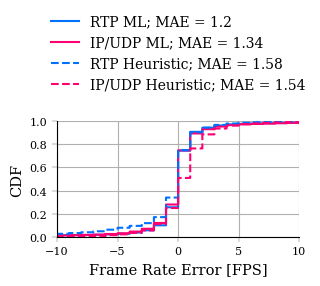

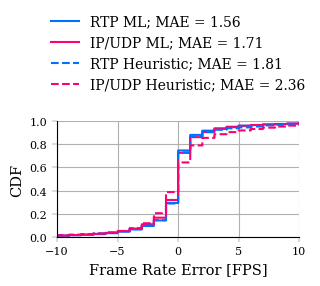

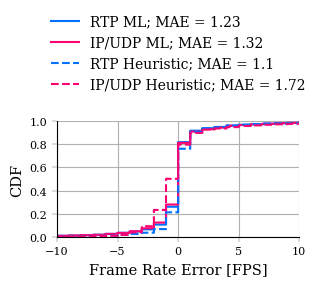

In [1035]:
df_fps = df[(df['metric'] == 'framesReceivedPerSecond')]
df_fps = df_fps.rename(columns={'method': 'Method'})
plot_fps(df_fps, 'meet')
plot_fps(df_fps, 'teams')
plot_fps(df_fps, 'webex')

In [1036]:
df_meet = df_fps[(df_fps['Method'] == 'IP/UDP ML') & (df_fps['VCA'] == 'meet')]
df_teams = df_fps[(df_fps['Method'] == 'IP/UDP ML') & (df_fps['VCA'] == 'teams')]
df_webex = df_fps[(df_fps['Method'] == 'IP/UDP ML') & (df_fps['VCA'] == 'webex')]

print(100*len(df_meet[(df_meet['deviation'] >= -2)&(df_meet['deviation'] <= 2)])/len(df_meet))
print(100*len(df_teams[(df_teams['deviation'] >= -2)&(df_teams['deviation'] <= 2)])/len(df_teams))
print(100*len(df_webex[(df_webex['deviation'] >= -2)&(df_webex['deviation'] <= 2)])/len(df_webex))

86.21294851794072
79.90801757276222
85.75127437494943


In [1037]:
def plot_bitrate(df_bitrate, vca):
    meet = df_bitrate[df_bitrate['VCA'] == vca]
    labels = []
    llabels = {}
    for txt in suffix_map.keys():
        d = meet[meet['Method'] == txt]
        mae = round(mean_absolute_error(d['Prediction'], d['Ground Truth'])/1000, 2)
        d['Method'] = d['Method'].map({txt: txt + f"; MAE = {mae}"})
        labels.append(d)
        llabels[txt] =  txt + f"; MAE = {mae}"
    meet = pd.concat(labels, axis=0)
    fig, ax = plt.subplots(1, 1)
    sns.ecdfplot(meet[meet['Method'].str.contains('RTP ML')], x = 'rel_deviation', ls=None, color=colors[0], ax=ax, label=llabels['RTP ML'])
    sns.ecdfplot(meet[meet['Method'].str.contains('IP/UDP ML')], x = 'rel_deviation', ls=None, color=colors[1], ax=ax, label=llabels['IP/UDP ML'])
    sns.ecdfplot(meet[meet['Method'].str.contains('RTP Heuristic')], x = 'rel_deviation', ls='--', color=colors[0], ax=ax, label=llabels['RTP Heuristic'])
    sns.ecdfplot(meet[meet['Method'].str.contains('IP/UDP Heuristic')], x = 'rel_deviation', ls='--', color=colors[1], ax=ax, label=llabels['IP/UDP Heuristic'])
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.15), ncol=1, frameon=False, title="")
    plt.grid(visible=1)
    plt.xlim([-1, 1])
    plt.xlabel('Relative Bitrate Error')
    plt.ylabel('CDF')
    plt.savefig(f'paper_plots/{vca}_bitrate_error_imc_lab.pdf', bbox_inches='tight')

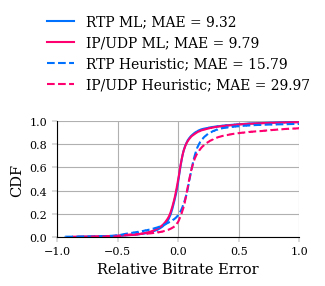

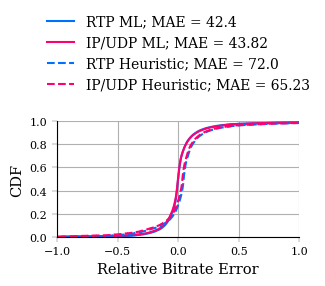

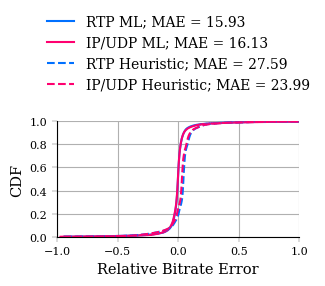

In [1038]:
df_bitrate = df[(df['metric'] == 'bitrate')]
df_bitrate['deviation'] /= 1000
df_bitrate['rel_deviation'] = 1000 * df_bitrate['deviation'] / df_bitrate['Ground Truth']
df_bitrate = df_bitrate.rename(columns={'method': 'Method'})
plot_bitrate(df_bitrate, 'meet')
plot_bitrate(df_bitrate, 'teams')
plot_bitrate(df_bitrate, 'webex')

In [1039]:
df_meet = df_bitrate[(df_bitrate['Method'] == 'IP/UDP ML') & (df_bitrate['VCA'] == 'meet')]
df_teams = df_bitrate[(df_bitrate['Method'] == 'IP/UDP ML') & (df_bitrate['VCA'] == 'teams')]
df_webex = df_bitrate[(df_bitrate['Method'] == 'IP/UDP ML') & (df_bitrate['VCA'] == 'webex')]
print(100*len(df_meet[(df_meet['deviation'] >= -50)&(df_meet['deviation'] <= 50)])/len(df_meet))
print(100*len(df_teams[(df_teams['deviation'] >= -50)&(df_teams['deviation'] <= 50)])/len(df_teams))
print(100*len(df_webex[(df_webex['deviation'] >= -50)&(df_webex['deviation'] <= 50)])/len(df_webex))

96.7921216848674
76.09143327841845
93.54316692289021


In [1040]:
print(100*len(df_meet[(df_meet['rel_deviation'] >= -0.25)&(df_meet['rel_deviation'] <= 0.25)])/len(df_meet))
print(100*len(df_teams[(df_teams['rel_deviation'] >= -0.25)&(df_teams['rel_deviation'] <= 0.25)])/len(df_teams))
print(100*len(df_webex[(df_webex['rel_deviation'] >= -0.25)&(df_webex['rel_deviation'] <= 0.25)])/len(df_webex))

87.29524180967239
89.56617243272927
94.99959543652399


In [1041]:
def plot_jitter(df_jitter, vca):
    meet = df_jitter[df_jitter['VCA'] == vca]
    labels = []
    llabels = {}
    for txt in suffix_map.keys():
        d = meet[meet['Method'] == txt]
        mae = round(mean_absolute_error(d['Prediction'], d['Ground Truth']), 2)
        d['Method'] = d['Method'].map({txt: txt + f"; MAE = {mae}"})
        labels.append(d)
        llabels[txt] =  txt + f"; MAE = {mae}"
    meet = pd.concat(labels, axis=0)
    fig, ax = plt.subplots(1, 1)
    sns.ecdfplot(meet[meet['Method'].str.contains('RTP ML')], x = 'deviation', ls=None, color=colors[0], ax=ax, label=llabels['RTP ML'])
    sns.ecdfplot(meet[meet['Method'].str.contains('IP/UDP ML')], x = 'deviation', ls=None, color=colors[1], ax=ax, label=llabels['IP/UDP ML'])
    sns.ecdfplot(meet[meet['Method'].str.contains('RTP Heuristic')], x = 'deviation', ls='--', color=colors[0], ax=ax, label=llabels['RTP Heuristic'])
    sns.ecdfplot(meet[meet['Method'].str.contains('IP/UDP Heuristic')], x = 'deviation', ls='--', color=colors[1], ax=ax, label=llabels['IP/UDP Heuristic'])
    plt.legend( loc='lower center', bbox_to_anchor=(0.5, 1.15), ncol=1, frameon=False, title="")
    plt.grid(visible=1)
    plt.xlim([-100, 100])
    plt.xlabel('Frame Jitter Error [ms]')
    plt.ylabel('CDF')
    plt.savefig(f'paper_plots/{vca}_jitter_error_imc_lab.pdf', bbox_inches='tight')

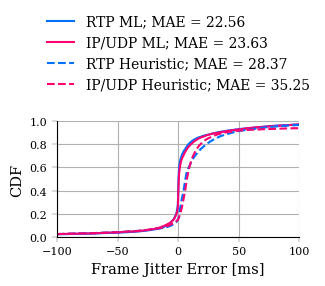

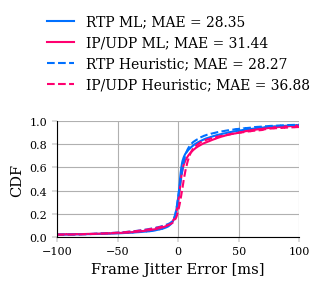

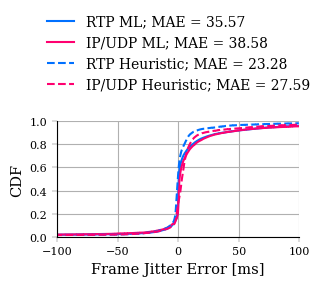

In [1042]:
df_jitter = df[(df['metric'] == 'frame_jitter')]
df_jitter = df_jitter.rename(columns={'method': 'Method'})
plot_jitter(df_jitter, 'meet')
plot_jitter(df_jitter, 'teams')
plot_jitter(df_jitter, 'webex')

54.25444515879144


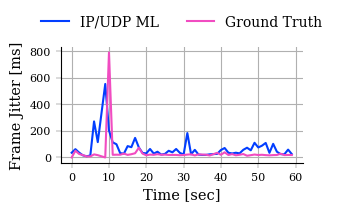

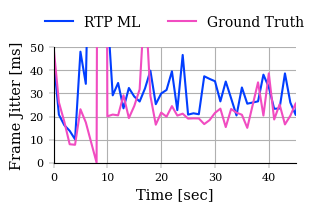

<Figure size 312.5x150 with 0 Axes>

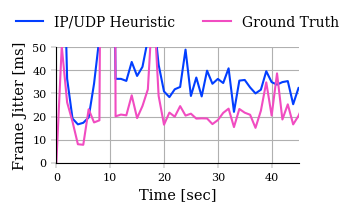

<Figure size 312.5x150 with 0 Axes>

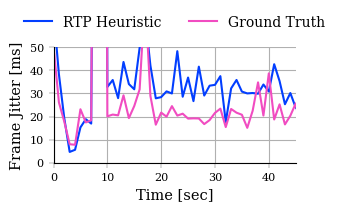

In [1043]:
teams = df_jitter[df_jitter['VCA'] == 'teams']
csv_file = teams['csv_file'].iloc[100]
tdf = teams[(teams['csv_file'] == csv_file)&(teams['Method'].str.contains('IP/UDP ML'))].sort_values(by='ts')
print(tdf['abs_deviation'].mean())
tdf['ts'] = tdf['ts'] - tdf['ts'].min()
fig, ax = plt.subplots(1, 1)
tdf.plot('ts', 'Prediction', ax=ax, label=f'IP/UDP ML', color = '#023eff')
tdf.plot('ts', 'Ground Truth', ax=ax, label='Ground Truth', color= '#f14cc1')
plt.grid(visible=1)
plt.xlabel('Time [sec]')
plt.ylabel('Frame Jitter [ms]')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
# plt.ylim([0, 50])
# plt.xlim([0, 45])
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('paper_plots/frame_jitter_ip_udp_ml.pdf', bbox_inches='tight')
fig, ax = plt.subplots(1, 1)
tdf = teams[(teams['csv_file'] == csv_file)&(teams['Method'].str.contains('RTP ML'))].sort_values(by='ts')
tdf['ts'] = tdf['ts'] - tdf['ts'].min()
tdf.plot('ts', 'Prediction', ax=ax, label=f'RTP ML', color = '#023eff')
tdf.plot('ts', 'Ground Truth', ax=ax, label='Ground Truth', color= '#f14cc1')
plt.grid(visible=1)
plt.xlabel('Time [sec]')
plt.ylabel('Frame Jitter [ms]')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
plt.ylim([0, 50])
plt.xlim([0, 45])
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('paper_plots/frame_jitter_rtp_ml.pdf', bbox_inches='tight')
plt.figure()
fig, ax = plt.subplots(1, 1)
tdf = teams[(teams['csv_file'] == csv_file) & (teams['Method'].str.contains('IP/UDP Heuristic'))].sort_values(by='ts')
tdf['ts'] = tdf['ts'] - tdf['ts'].min()
tdf.plot('ts', 'Prediction', ax=ax, label=f'IP/UDP Heuristic', color = '#023eff')
tdf.plot('ts', 'Ground Truth', ax=ax, label='Ground Truth', color= '#f14cc1')
plt.grid(visible=1)
plt.xlabel('Time [sec]')
plt.ylabel('Frame Jitter [ms]')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
plt.ylim([0, 50])
plt.xlim([0, 45])
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('paper_plots/frame_jitter_ip_udp_non_ml.pdf', bbox_inches='tight')
plt.figure()
fig, ax = plt.subplots(1, 1)
tdf = teams[(teams['csv_file'] == csv_file)&(teams['Method'].str.contains('RTP Heuristic'))].sort_values(by='ts')
tdf['ts'] = tdf['ts'] - tdf['ts'].min()
tdf.plot('ts', 'Prediction', ax=ax, label=f'RTP Heuristic', color = '#023eff')
tdf.plot('ts', 'Ground Truth', ax=ax, label='Ground Truth', color= '#f14cc1')
plt.grid(visible=1)
plt.xlabel('Time [sec]')
plt.ylabel('Frame Jitter [ms]')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
plt.ylim([0, 50])
plt.xlim([0, 45])
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('paper_plots/frame_jitter_rtp_non_ml.pdf', bbox_inches='tight')

[180.0, 270.0, 360.0]
meet
[9069 1055]
[90.0, 116.0, 134.0, 176.0, 180.0, 234.0, 270.0, 360.0, 404.0, 540.0, 720.0]
teams
[4971 1780 3461 4115]
[180.0, 360.0]
webex
[   92 12199]


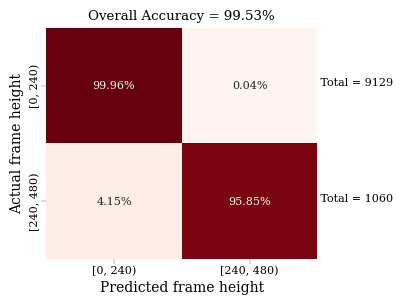

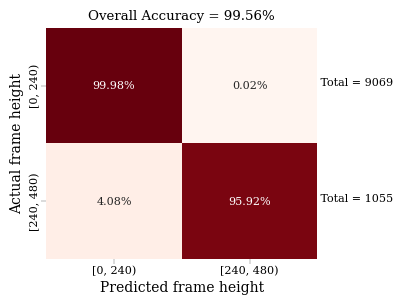

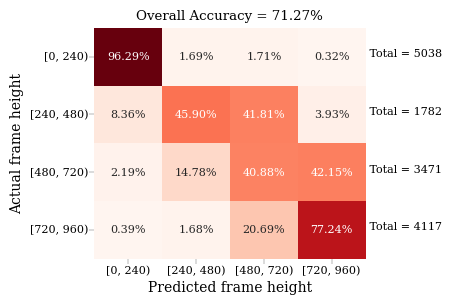

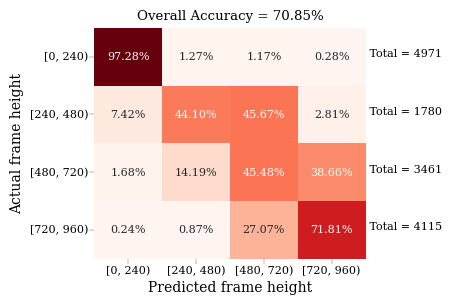

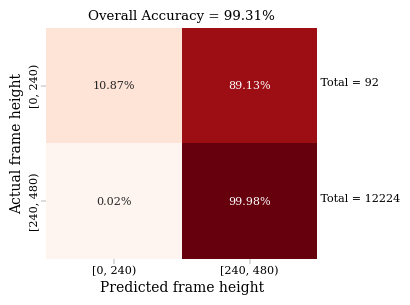

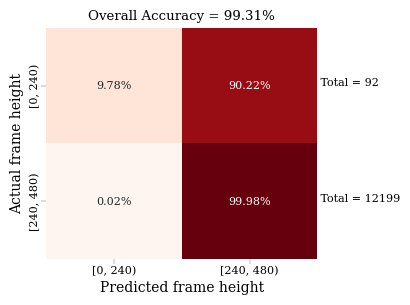

In [1087]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

df_frameHeight = df[(df['metric'] == 'frameHeight')]

def bin_res(x):
    if x >= 0 and x < 240:
        return "[0, 240)"
    elif x >= 240 and x < 480:
        return "[240, 480)"
    elif x >= 480 and x < 720:
        return "[480, 720)"
    else:
        return "[720, 960)"

for vca in tested_vcas:
    teams = df_frameHeight[df_frameHeight['VCA'] == vca]
    print(sorted(teams["Ground Truth"].unique()))
    teams["Prediction"] = teams["Prediction"].apply(bin_res)
    teams["Ground Truth"] = teams["Ground Truth"].apply(bin_res)
    print(vca)
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
    udp = teams[teams['method'] == 'IP/UDP ML']
    labels=sorted(list(udp['Ground Truth'].unique()))
    ccounts = np.unique(udp['Ground Truth'], return_counts=True)[1]
    cperc = ccounts / len(udp['Ground Truth'])
    cm = confusion_matrix(y_pred=udp['Prediction'], y_true=udp['Ground Truth'], labels=labels)
    f1 = round(100*accuracy_score(udp['Prediction'], udp['Ground Truth']), 2)
    cm_norm = 100*cm / cm.sum(axis=1, keepdims=True)
    cm_norm[np.isnan(cm_norm)] = 0
    total = cm.sum(axis=1, keepdims=True).flatten()
    p = len(total)
    formatted_text = np.asarray(["{0:.2f}%".format(a) for a in cm_norm.flatten()]).reshape(cm.shape[0], cm.shape[1])
    sns.heatmap(cm_norm, annot=formatted_text, cmap='Reds', fmt='', xticklabels=labels, yticklabels=labels, cbar=False, ax=ax)
    i = 0
    for x,y in zip(total, ccounts):
        plt.annotate(f" Total = {y}", xy=(p, i+0.5))
        i += 1
    ax.tick_params(pad=1)
    ax.set_title(f'Overall Accuracy = {f1}%')
    ax.set_ylabel('Actual frame height')
    ax.set_xlabel('Predicted frame height')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    plt.savefig(f'paper_plots/{vca}_resolution_cm_imc_lab_ip.pdf', bbox_inches='tight')

    fig, ax = plt.subplots(1, 1, figsize=(3.5,3))
    rtp = teams[teams['method'] == 'RTP ML']
    labels=sorted(list(rtp['Ground Truth'].unique()))
    ccounts = np.unique(rtp['Ground Truth'], return_counts=True)[1]
    print(ccounts)
    cperc = ccounts / len(rtp['Ground Truth'])
    cm = confusion_matrix(y_pred=rtp['Prediction'], y_true=rtp['Ground Truth'], labels=labels)
    f1 = round(100*accuracy_score(rtp['Prediction'], rtp['Ground Truth']), 2)
    cm_norm = 100*cm / cm.sum(axis=1, keepdims=True)
    cm_norm[np.isnan(cm_norm)] = 0
    total = cm.sum(axis=1, keepdims=True).flatten()
    formatted_text = np.asarray(["{0:.2f}%".format(a) for a in cm_norm.flatten()]).reshape(cm.shape[0], cm.shape[1])
    sns.heatmap(cm_norm, annot=formatted_text, cmap='Reds', fmt='', xticklabels=labels, yticklabels=labels, cbar=False, ax=ax)
    i = 0
    for x,y in zip(total, ccounts):
        plt.annotate(f" Total = {y}", xy=(p, i+0.5))
        i += 1
    ax.tick_params(pad=1)
    ax.set_title(f'Overall Accuracy = {f1}%')
    ax.set_ylabel('Actual frame height')
    ax.set_xlabel('Predicted frame height')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    plt.savefig(f'paper_plots/{vca}_resolution_cm_imc_lab_rtp.pdf', bbox_inches='tight')

# Feature Importance Scores

In [1055]:
def plot_feature_importance(f_rtp, f_udp, metric):
    for vca in f_rtp[metric][1].keys():
        print(vca)
        scores_rtp = {}
        for cv in f_rtp[metric].keys():
            for feature in f_rtp[metric][cv][vca].keys():
                if feature_map[feature] not in scores_rtp:
                    scores_rtp[feature_map[feature]] = []
                scores_rtp[feature_map[feature]].append(100*f_rtp[metric][cv][vca][feature])
        scores_udp = {}
        for cv in f_udp[metric].keys():
            for feature in f_udp[metric][cv][vca].keys():
                if feature_map[feature] not in scores_udp:
                    scores_udp[feature_map[feature]] = []
                scores_udp[feature_map[feature]].append(100*f_udp[metric][cv][vca][feature])
                
        mmap = {'framesReceivedPerSecond': 'Frames Per Second', 'bitrate': 'Bitrate', 'frame_jitter': 'Frame Jitter', 'frameHeight': 'FrameHeight'}
        if vca == 'meet':
            vc_name = 'Meet'
        elif vca == 'teams':
            vc_name = 'Teams'
        elif vca == 'webex':
            vc_name = 'Webex'
        
        fig, ax = plt.subplots(1, 1, figsize=[1.0*3.125, 1.5*1.0])
        topk = pd.DataFrame(scores_rtp).mean().sort_values(ascending=False).head(10).sort_values()
        plt.barh(topk.index, topk.values, color=colors[5])
        plt.xlabel(f'Feature Importance [%]')
        plt.ylabel('Feature')
        plt.xlim([0, 100])
        plt.gca().xaxis.grid(True)
        # plt.grid(visible=1)
        ax.spines[['right', 'top']].set_visible(False)
        plt.savefig(f'paper_plots/{vca}_{metric}_rtp_ml_feature_importance_imc_lab.pdf', bbox_inches='tight')
        
        fig, ax = plt.subplots(1, 1, figsize=[1.0*3.125, 1.5*1.0])
        topk = pd.DataFrame(scores_udp).mean().sort_values(ascending=False).head(10).sort_values()
        plt.barh(topk.index, topk.values, color=colors[5])
        plt.xlabel(f'Feature Importance [%]')
        plt.ylabel('Feature')
        plt.xlim([0, 100])
        plt.gca().xaxis.grid(True)
        # plt.grid(visible=1)
        ax.spines[['right', 'top']].set_visible(False)
        plt.savefig(f'paper_plots/{vca}_{metric}_ip_udp_ml_feature_importance_imc_lab.pdf', bbox_inches='tight')

meet
teams
webex


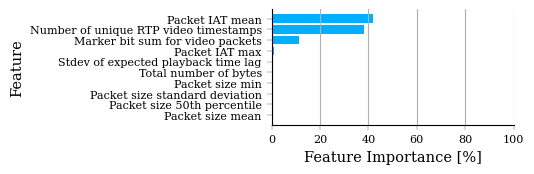

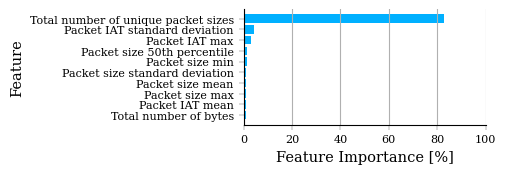

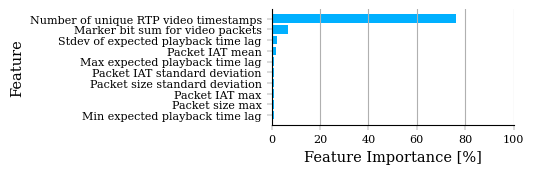

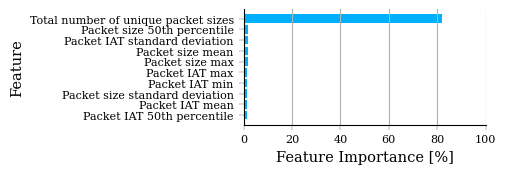

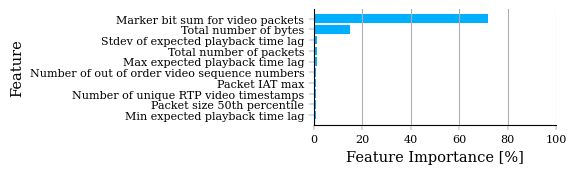

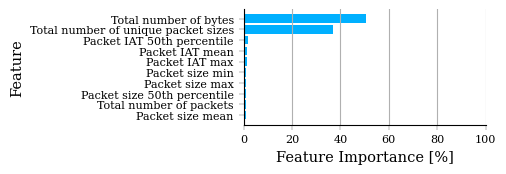

In [1056]:
plot_feature_importance(f_rtp_ml, f_udp_ml, 'framesReceivedPerSecond')

meet
teams
webex


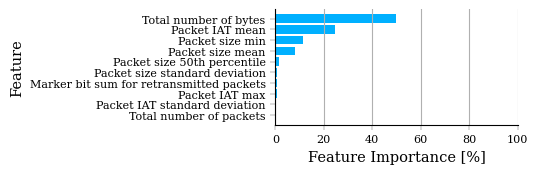

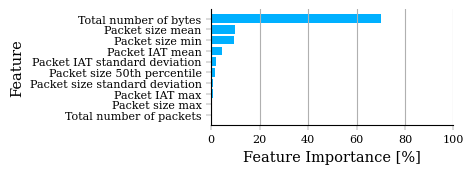

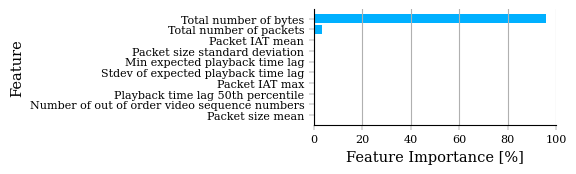

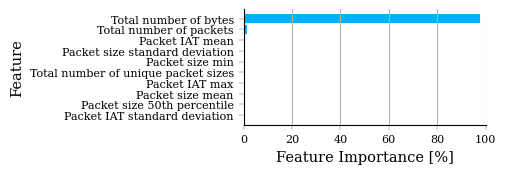

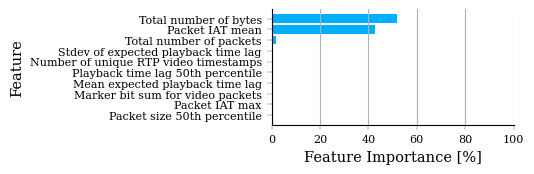

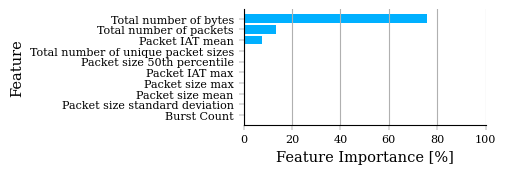

In [1057]:
plot_feature_importance(f_rtp_ml, f_udp_ml, 'bitrate')

meet
teams
webex


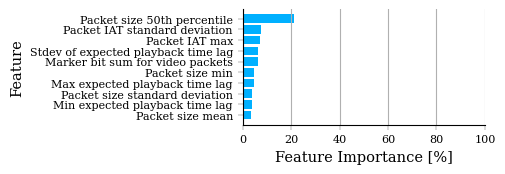

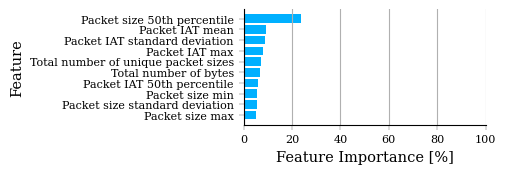

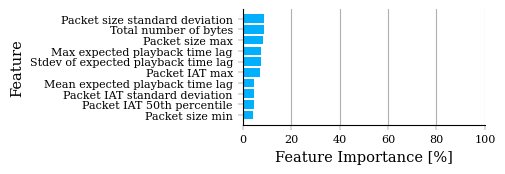

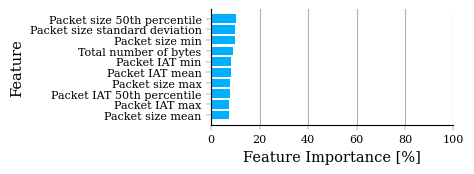

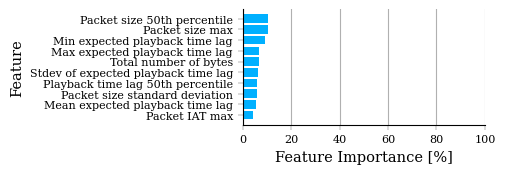

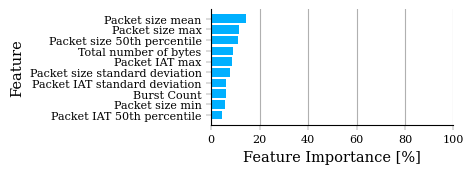

In [1058]:
plot_feature_importance(f_rtp_ml, f_udp_ml, 'frame_jitter')

meet
teams
webex


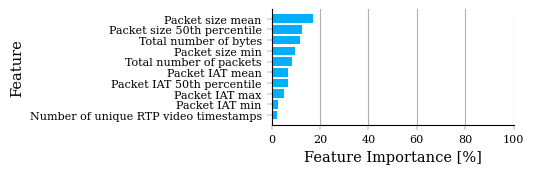

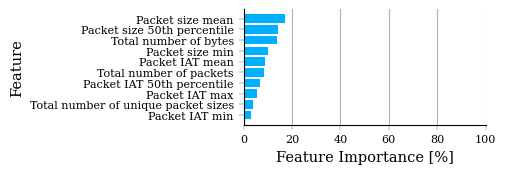

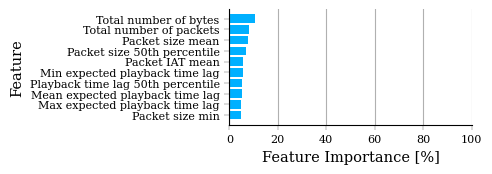

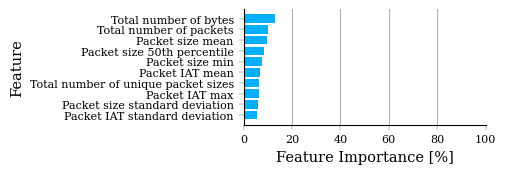

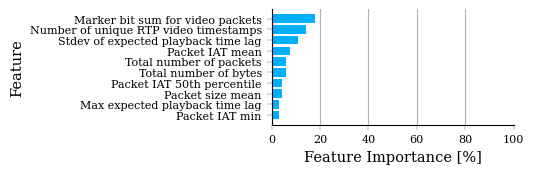

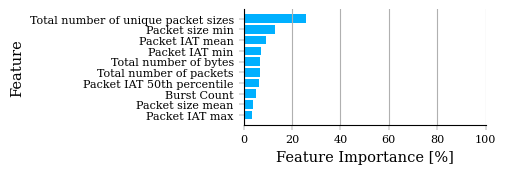

In [1059]:
plot_feature_importance(f_rtp_ml, f_udp_ml, 'frameHeight')

### Ground Truth Distributions

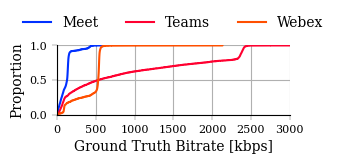

In [1143]:
df = pd.read_csv('imc_lab_results.csv', index_col=None)
fig, ax = plt.subplots(1, 1)
df['bitrate_kbps'] = df['bitrate']/1000
sns.ecdfplot(data=df[df['VCA'] == 'meet'], x = 'bitrate_kbps', color = colors[-1], ax=ax, label='Meet')
sns.ecdfplot(data=df[df['VCA'] == 'teams'], x = 'bitrate_kbps', color=colors[7], ax=ax, label='Teams')
sns.ecdfplot(data=df[df['VCA'] == 'webex'], x = 'bitrate_kbps', color=colors[9], ax=ax, label='Webex')
plt.xlabel('Ground Truth Bitrate [kbps]')
plt.grid(visible=1)
plt.xlim([0, 3000])
#add legend to plot
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
plt.savefig('paper_plots/gt_bitrate_imc_lab.pdf', bbox_inches='tight')

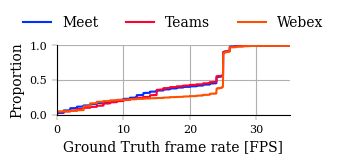

In [1144]:
fig, ax = plt.subplots(1, 1)
sns.ecdfplot(data=df[df['VCA'] == 'meet'], x = 'framesReceivedPerSecond', color=colors[-1], ax=ax, label='Meet')
sns.ecdfplot(data=df[df['VCA'] == 'teams'], x = 'framesReceivedPerSecond', color=colors[7], ax=ax, label='Teams')
sns.ecdfplot(data=df[df['VCA'] == 'webex'], x = 'framesReceivedPerSecond', color=colors[9], ax=ax, label='Webex')
plt.xlabel('Ground Truth frame rate [FPS]')
plt.grid(visible=1)
plt.xlim([0, 35])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
plt.savefig('paper_plots/gt_fps_imc_lab.pdf', bbox_inches='tight')

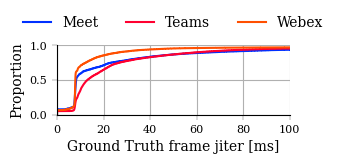

In [1145]:
fig, ax = plt.subplots(1, 1)
sns.ecdfplot(data=df[df['VCA'] == 'meet'], x = 'frame_jitter', color=colors[-1], ax=ax, label='Meet')
sns.ecdfplot(data=df[df['VCA'] == 'teams'], x = 'frame_jitter', color=colors[7], ax=ax, label='Teams')
sns.ecdfplot(data=df[df['VCA'] == 'webex'], x = 'frame_jitter', color=colors[9], ax=ax, label='Webex')
plt.xlabel('Ground Truth frame jiter [ms]')
plt.grid(visible=1)
plt.xlim([0, 100])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
plt.savefig('paper_plots/gt_jitter_imc_lab.pdf', bbox_inches='tight')

In [945]:
df[df['metric'] == 'frame_jitter']['Ground Truth'].mean()

31.265112040552445

# Packet Size Distribution Meet vs Teams

In [520]:
import pandas as pd
mcsv = '../../data/conext_data/logs_Meet_06-15_rush_hour/capture/3086_528_27783_259_53_1655334546.csv'
mw = WebRTCReader('../../data/conext_data/logs_Meet_06-15_rush_hour/webrtc/3086_528_27783_259_53_1655334546.json', 'conext_data').get_webrtc()
tw = WebRTCReader('../../data/conext_data/logs_Teams_06-15_rush_hour/webrtc/3085_999_198994_74624_50_1655406559.json', 'conext_data').get_webrtc()
tcsv = '../../data/conext_data/logs_Teams_06-15_rush_hour/capture/3085_999_198994_74624_50_1655406559.csv'
net_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker']
m = pd.read_csv(mcsv, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii').sort_values(by='frame.time_relative')
t = pd.read_csv(tcsv, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii').sort_values(by='frame.time_relative')
m = m[m['udp.length'] > 304]
t = t[t['udp.length'] > 304]

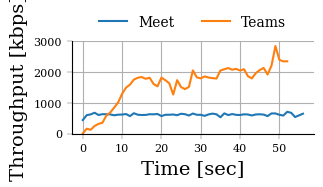

In [521]:
m['ts'] = m['frame.time_epoch'].apply(int)
t['ts'] = t['frame.time_epoch'].apply(int)
m = m.groupby('ts')['udp.length'].sum().reset_index()
t = t.groupby('ts')['udp.length'].sum().reset_index()
mw['bitrate'] /= 1000
m['udp.length'] *= (8/1000)
tw['bitrate'] /= 1000
t['udp.length'] *= (8/1000)
m_ = pd.merge(m, mw, on='ts')
t_ = pd.merge(t, tw, on='ts')
m_['ts_rel'] = m_['ts']-m_['ts'].min()
t_['ts_rel'] = t_['ts']-t_['ts'].min()
fig, ax = plt.subplots(1,1)
m_.groupby('ts_rel')[['udp.length']].max().plot(label='Meet', ax=ax)
t_.groupby('ts_rel')[['udp.length']].max().plot(label='Teams', ax=ax)
plt.xlabel('Time [sec]')
plt.ylabel('Throughput [kbps]')
plt.ylim([0, 3000])
plt.grid(visible=1)
plt.legend(labels=['Meet', 'Teams'], loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2, frameon=False)
plt.savefig('paper_plots/throughput_comparison.pdf', bbox_inches='tight')

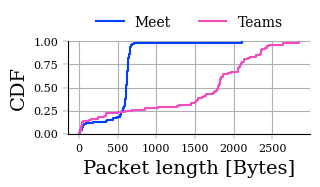

In [522]:
fig, ax = plt.subplots(1, 1)

sns.ecdfplot(data=m, x = 'udp.length', color='#023eff')
sns.ecdfplot(data=t, x = 'udp.length', color= '#f14cc1')
plt.grid(visible=1)
plt.legend(labels=['Meet', 'Teams'], loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2, frameon=False)
plt.xlabel('Packet length [Bytes]')
plt.ylabel('CDF')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('paper_plots/udp_length_comparison.pdf', bbox_inches='tight')

# Lookback Tuning

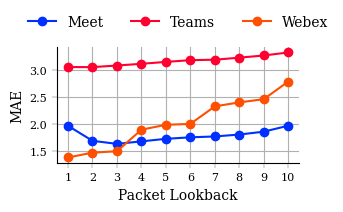

In [1123]:
dm1 = pd.read_csv('meet_lookback_imc.csv')
dt1 = pd.read_csv('teams_lookback_imc.csv')
dw1 = pd.read_csv('webex_lookback_imc.csv')
# dm2 = pd.read_csv('meet_lookback_imc_11_20.csv')
# dt2 = pd.read_csv('teams_lookback_imc_11_20.csv')
# dw2 = pd.read_csv('webex_lookback_imc_11_20.csv')

# dm = pd.concat((dm1, dm2), axis=0)
# dt = pd.concat((dt1, dt2), axis=0)
# dw = pd.concat((dw1, dw2), axis=0)

# print(dm.groupby('L')['MAE'].mean())
# print(dt.groupby('L')['MAE'].mean())
# print(dw.groupby('L')['MAE'].mean())
fig, ax = plt.subplots(1,1, figsize=(1.0*3.125, 1.5*1.0))
dm1.groupby('L')['MAE'].mean().plot(marker='o', ax=ax, label='Meet', color = colors[-1])
dt1.groupby('L')['MAE'].mean().plot(marker='o', ax=ax, label='Teams', color=colors[7])
dw1.groupby('L')['MAE'].mean().plot(marker='o', ax=ax, label='Webex', color=colors[9])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False, labels=['Meet', 'Teams', 'Webex'])
ax.set_ylabel('MAE')
ax.set_xlabel('Packet Lookback')
# ax.set_xlim([0, 16])
ax.set_xticks(list(range(1, 11)))
ax.grid(visible=1)
plt.savefig('paper_plots/lookback_tuning.pdf', bbox_inches='tight')

In [931]:
print(dm[(dm['L'] == 3)][['frac_interleave', 'frac_coalesce']].mean().mul(100))
print(dt[(dt['L'] == 2)][['frac_interleave', 'frac_coalesce']].mean().mul(100))
print(dw[(dw['L'] == 1)][['frac_interleave', 'frac_coalesce']].mean().mul(100))

frac_interleave   6.23
frac_coalesce     3.04
dtype: float64
frac_interleave   1.99
frac_coalesce     2.29
dtype: float64
frac_interleave   0.58
frac_coalesce     3.61
dtype: float64


## Toy Example Showing Inaccuracies

In [600]:
df_fps[df_fps['abs_deviation'] > 5]['csv_file'].iloc[137]

'/home/taveesh/Documents/Projects/vca-qoe-inference/data/IMC_Lab_data/2023-05-16_teams_3805_1108_45_21_2_48_288/teams/captures/teams-chrome-3805_1108_45_21_2_48_288-1684281948.csv'

In [932]:
csv_file = '/home/taveesh/Documents/Projects/vca-qoe-inference/data/IMC_Lab_data/2023-05-16_teams_101_24_66_1_0_41_49/teams/captures/teams-chrome-101_24_66_1_0_41_49-1684258502.csv'
net_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker']
df = pd.read_csv(csv_file, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii')
dfg = df.groupby('rtp.timestamp').agg(max_size=('udp.length', max), min_size = ('udp.length', min)).reset_index()
if df['ip.proto'].dtype == object:
    df = df[df['ip.proto'].str.contains(',') == False]
df = df[~df['ip.proto'].isna()]
df['ip.proto'] = df['ip.proto'].astype(int)
df = df[(df['ip.proto'] == 17) & (df['ip.dst'] == '192.168.1.187')]
src = df.groupby('ip.src').agg({'udp.length': sum, 'rtp.p_type': 'count'}).reset_index().sort_values(by='udp.length', ascending=False).head(1)['ip.src'].iloc[0]
df = df[df['ip.src'] == src]

df = df[df['udp.length'] > 306]
df = df.sort_values(by=['frame.time_relative'])
frame_id_assignment = [-1 for _ in range(df.shape[0])]
frame_id = 1
l = 2
for i in range(df.shape[0]):
    found = False
    s = df.iloc[i]['udp.length']
    for j in range(i-1, max(0, i-l-1), -1):
        if abs(df.iloc[j]['udp.length'] - s) <= 2:
            frame_id_assignment[i] = frame_id
            found = True
            break
    if not found:
        frame_id += 1
        frame_id_assignment[i] = frame_id
df["frame_num"] = frame_id_assignment
dfc = df.groupby("frame_num").agg({"rtp.timestamp": (lambda x: len(set(x)))})
coal = len(dfc[dfc["rtp.timestamp"] > 1]) / len(dfc)
dfi = df.groupby("rtp.timestamp").agg({"frame_num": (lambda x: len(set(x)))})
il = len(dfi[dfi["frame_num"] > 1]) / len(dfi)

6 4


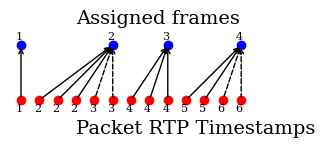

In [933]:
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize' : [1.0*3.125, 1.0],
                           'legend.fontsize': 10, 'legend.fancybox': True,
                           'font.family': 'serif', 'font.sans-serif': 'Times',
                            'xtick.major.width': 0.2, 'xtick.minor.width': 2*0.2,
                            'ytick.major.width': 0.2, 'ytick.minor.width': 2*0.2,
                            'text.usetex': False, 'axes.labelsize': 7*2,
                            'axes.spines.right': False, 'axes.spines.top': False
                           })
from collections import defaultdict
df['et'] = df['frame.time_relative'].apply(int)
dfs = df[(df['et'] == 30)]
rtps = dfs['rtp.timestamp'].tolist()
fnums = dfs['frame_num'].tolist()
times = dfs['frame.time_relative'].tolist()
rtp_set = sorted(list(set(rtps)))
fnum_set = sorted(list(set(fnums)))
print(len(rtp_set), len(fnum_set))
rtp_idx = {rtp_set[i]: i for i in range(len(rtp_set))}
fnum_idx = {fnum_set[i]: i for i in range(len(fnum_set))}
rel = [(i, fnum_idx[fnums[i]]) for i in range(len(rtps))]
max_idx = defaultdict(lambda: -1)
for a, b in rel:
    max_idx[b] = max(max_idx[b], a)
top_x = [max_idx[x] for x in max_idx.keys()]
a_y_ = sorted(rtps)
b_y_ = sorted(fnums)
a_y = [rtp_idx[x] for x in a_y_]
b_y = [fnum_idx[x] for x in b_y_]
a_x = [1 for i in range(len(a_y))]
b_x = [2 for i in range(len(fnum_idx))]
plt.figure()
plt.scatter(list(range(len(a_y))), a_x, c='r')
plt.scatter(top_x, b_x, c='b')
plt.margins(y=0.2)
for i in range(len(rtps)):
    plt.annotate(xy=(i-0.3, 0.8), text=f'{rtp_idx[rtps[i]]+1}', fontsize=8)
for i in range(len(fnum_idx)):
    plt.annotate(xy=(max_idx[i]-0.3, 2+0.1), text=f'{i+1}', fontsize=8)
for i1, i2 in rel:
    if i1 in [4, 5, 11, 12]:
        plt.annotate(xy=(i1,1), xytext=(max_idx[i2], 2), arrowprops=dict(arrowstyle='<-', ls = '--') , text='')
    else:
        plt.annotate(xy=(i1,1), xytext=(max_idx[i2], 2), arrowprops=dict(arrowstyle='<-') , text='')
plt.text(x =3, y = 0.4, s = 'Packet RTP Timestamps', fontsize=14)
plt.text(x =3, y = 2.4, s = 'Assigned frames', fontsize=14)
plt.yticks([])
plt.xticks([])
plt.box(False)
plt.savefig('paper_plots/coalesces.pdf', bbox_inches='tight')

In [934]:
dfs

,frame.time_relative,frame.time_epoch,ip.src,ip.dst,ip.proto,ip.len,udp.srcport,udp.dstport,udp.length,rtp.ssrc,rtp.timestamp,rtp.seq,rtp.p_type,rtp.marker,frame_num,et
2608,30.02,1684258532.99,52.113.209.76,192.168.1.187,17,912,3480.00,47988.00,892.00,0x00009d3a,337776537.00,18842.00,102.00,1.00,104,30
2611,30.11,1684258533.09,52.113.209.76,192.168.1.187,17,1041,3480.00,47988.00,1021.00,0x00009d3a,337779614.00,18843.00,102.00,0.00,105,30
2613,30.19,1684258533.17,52.113.209.76,192.168.1.187,17,1041,3480.00,47988.00,1021.00,0x00009d3a,337779614.00,18844.00,102.00,0.00,105,30
2617,30.27,1684258533.25,52.113.209.76,192.168.1.187,17,1042,3480.00,47988.00,1022.00,0x00009d3a,337779614.00,18845.00,102.00,1.00,105,30
2620,30.35,1684258533.33,52.113.209.76,192.168.1.187,17,1040,3480.00,47988.00,1020.00,0x00009d3a,337783708.00,18846.00,102.00,0.00,105,30
2622,30.43,1684258533.41,52.113.209.76,192.168.1.187,17,1040,3480.00,47988.00,1020.00,0x00009d3a,337783708.00,18847.00,102.00,1.00,105,30
2624,30.51,1684258533.49,52.113.209.76,192.168.1.187,17,1028,3480.00,47988.00,1008.00,0x00009d3a,337786341.00,18848.00,102.00,0.00,106,30
2626,30.59,1684258533.57,52.113.209.76,192.168.1.187,17,1028,3480.00,47988.00,1008.00,0x00009d3a,337786341.00,18849.00,102.00,0.00,106,30
2628,30.67,1684258533.65,52.113.209.76,192.168.1.187,17,1028,3480.00,47988.00,1008.00,0x00009d3a,337786341.00,18850.00,102.00,1.00,106,30
2631,30.75,1684258533.73,52.113.209.76,192.168.1.187,17,1032,3480.00,47988.00,1012.00,0x00009d3a,337790599.00,18851.00,102.00,0.00,107,30


meet 3.0
meet 4.0
0.8140382942841123


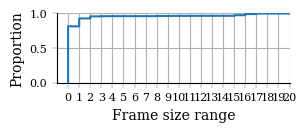

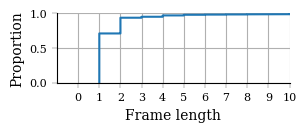

In [1137]:
res = pd.read_csv('imc_lab_results.csv')
res = res[(res['metric'] == 'framesReceivedPerSecond') & (res['method'] == 'IP/UDP Heuristic') & (res['VCA'] == 'meet')]
csv_files = list(res['csv_file'].unique())
net_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker']
data = []
for wcsv in csv_files:
    m = pd.read_csv(wcsv, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii').sort_values(by='frame.time_relative')
    m = m[(~m['rtp.ssrc'].isna()) & (m['udp.length'] > 306) & (m['ip.dst'] == '192.168.1.187')]
    data.append(m.groupby('rtp.timestamp').agg({'udp.length': lambda x: max(x) - min(x), 'frame.time_epoch': len}).reset_index())
m = pd.concat(data, axis=0)
plt.figure()
sns.ecdfplot(data=m, x = 'udp.length')
plt.xlim([-1, 20])
plt.xticks(np.arange(21))
plt.xlabel('Frame size range')
plt.grid()
print('meet', m['udp.length'].quantile(0.96))
print('meet', m['frame.time_epoch'].quantile(0.96))
print(m[m['udp.length'] == 0].shape[0] / m.shape[0])
plt.figure()
sns.ecdfplot(data=m, x = 'frame.time_epoch')
plt.xlim([-1, 10])
plt.xlabel('Frame length')
plt.xticks(np.arange(11))
plt.grid()

In [1138]:
print(100*m[m['udp.length'] <= 2].shape[0] / m.shape[0])
print(100*m[m['frame.time_epoch'] < 4].shape[0] / m.shape[0])

95.73482731370497
95.18076544419868


teams 1.0
teams 13.0


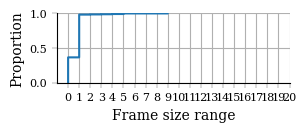

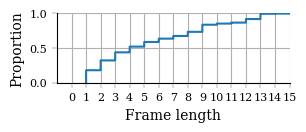

In [1135]:
res = pd.read_csv('imc_lab_results.csv')
res = res[(res['metric'] == 'framesReceivedPerSecond') & (res['method'] == 'IP/UDP Heuristic') & (res['VCA'] == 'teams')]
csv_files = list(res['csv_file'].unique())[:100]
net_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker']
data = []
for wcsv in csv_files:
    m = pd.read_csv(wcsv, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii').sort_values(by='frame.time_relative')
    m = m[(~m['rtp.ssrc'].isna()) & (m['udp.length'] > 306) & (m['ip.dst'] == '192.168.1.187')]
    data.append(m.groupby('rtp.timestamp').agg({'udp.length': lambda x: max(x) - min(x), 'frame.time_epoch': len}).reset_index())
m = pd.concat(data, axis=0)
plt.figure()
sns.ecdfplot(data=m, x = 'udp.length')
plt.xlim([-1, 20])
plt.xticks(np.arange(21))
plt.xlabel('Frame size range')
plt.grid()
print('teams', m['udp.length'].quantile(0.96))
print('teams', m['frame.time_epoch'].quantile(0.96))
plt.figure()
sns.ecdfplot(data=m, x = 'frame.time_epoch')
plt.xlim([-1, 15])
plt.xlabel('Frame length')
plt.xticks(np.arange(16))
plt.grid()

In [1136]:
print(100*m[m['udp.length'] <= 2].shape[0] / m.shape[0])
print(100*m[m['frame.time_epoch'] < 4].shape[0] / m.shape[0])

98.56872831228429
43.82681800656391


webex 2.0
webex 3.0


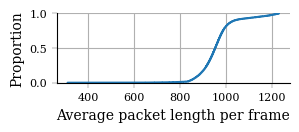

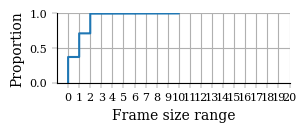

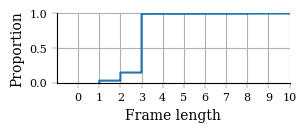

In [1133]:
res = pd.read_csv('imc_lab_results.csv')
res = res[(res['metric'] == 'framesReceivedPerSecond') & (res['method'] == 'IP/UDP Heuristic') & (res['VCA'] == 'webex')]
csv_files = list(res['csv_file'].unique())[:100]
net_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker']
data = []
for wcsv in csv_files:
    m = pd.read_csv(wcsv, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii').sort_values(by='frame.time_relative')
    m = m[(~m['rtp.ssrc'].isna()) & (m['udp.length'] > 306) & (m['ip.dst'] == '192.168.1.187')]
    data.append(m.groupby('rtp.timestamp').agg(size_range = ('udp.length', lambda x: max(x) - min(x)), avg_size=('udp.length', 'mean'), frame_len=('frame.time_epoch', len)).reset_index())
m = pd.concat(data, axis=0)
plt.figure()
sns.ecdfplot(data=m, x = 'avg_size')
plt.xlabel('Average packet length per frame')
plt.grid()
plt.figure()
sns.ecdfplot(data=m, x = 'size_range')
plt.xlim([-1, 20])
plt.xticks(np.arange(21))
plt.xlabel('Frame size range')
plt.grid()
print('webex', m['size_range'].quantile(0.96))
print('webex', m['frame_len'].quantile(0.96))
plt.figure()
sns.ecdfplot(data=m, x = 'frame_len')
plt.xlim([-1, 10])
plt.xlabel('Frame length')
plt.xticks(np.arange(11))
plt.grid()

In [1134]:
print(100*m[m['size_range'] <= 2].shape[0] / m.shape[0])
print(100*m[m['frame_len'] < 4].shape[0] / m.shape[0])

99.70169542725522
99.3890420269607


In [1068]:
dfm = pd.read_csv('meet_lookback_inaccuracies.csv')
dfm['frac_interleave'] *= 100
# dfm['frac_interleave_exact'] = dfm['frac_interleave'] - dfm['frac_splits']
dfm['frac_coalesce'] *= 100
dfm['frac_splits'] *= 100
dft = pd.read_csv('teams_lookback_inaccuracies.csv')
dft['frac_interleave'] *= 100
# dft['frac_interleave_exact'] = dft['frac_interleave'] - dft['frac_splits']
dft['frac_coalesce'] *= 100
dft['frac_splits'] *= 100
dfw = pd.read_csv('webex_lookback_inaccuracies.csv')
dfw['frac_interleave'] *= 100
# dfw['frac_interleave_exact'] = dfw['frac_interleave'] - dfw['frac_splits']
dfw['frac_coalesce'] *= 100
dfw['frac_splits'] *= 100

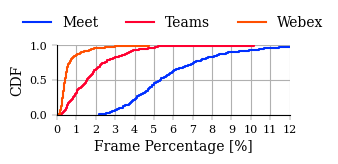

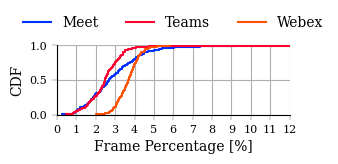

In [1069]:
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize' : [1.0*3, 1.5*0.6],
                           'legend.fontsize': 10, 'legend.fancybox': True,
                           'font.family': 'serif', 'font.sans-serif': 'Times',
                            'xtick.major.width': 0.2, 'xtick.minor.width': 2*0.2,
                            'ytick.major.width': 0.2, 'ytick.minor.width': 2*0.2,
                            'text.usetex': False, 'axes.labelsize': 10,
                            'axes.spines.right': False, 'axes.spines.top': False
                           })
# fig, ax = plt.subplots(1, 1)
# sns.ecdfplot(data=dfm, x = 'frac_splits', label='Meet', ax=ax, color = colors[0])
# sns.ecdfplot(data=dft, x = 'frac_splits', label='Teams', ax=ax, color=colors[1])
# sns.ecdfplot(data=dfw, x = 'frac_splits', label='Webex', ax=ax, color=colors[2])
# plt.xlabel('Frame Percentage [%]')
# plt.ylabel('CDF')
# ax.legend()
# ax.grid()
# ax.set_xlim([0, 12])
# ax.set_xticks(list(range(13)))
# plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
# plt.savefig('paper_plots/frame_splits_imc_lab.pdf', bbox_inches='tight')


fig, ax = plt.subplots(1, 1)
sns.ecdfplot(data=dfm, x = 'frac_interleave', label='Meet', ax=ax, color = colors[-1])
sns.ecdfplot(data=dft, x = 'frac_interleave', label='Teams', ax=ax, color=colors[7])
sns.ecdfplot(data=dfw, x = 'frac_interleave', label='Webex', ax=ax, color=colors[9])
plt.xlabel('Frame Percentage [%]')
plt.ylabel('CDF')
ax.legend()
ax.grid()
ax.set_xlim([0, 12])
ax.set_xticks(list(range(13)))
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
plt.savefig('paper_plots/frame_splits_imc_lab.pdf', bbox_inches='tight')

fig, ax = plt.subplots(1, 1)
sns.ecdfplot(data=dfm, x = 'frac_coalesce', label='Meet', ax=ax, color = colors[-1])
sns.ecdfplot(data=dft, x = 'frac_coalesce', label='Teams', ax=ax, color=colors[7])
sns.ecdfplot(data=dfw, x = 'frac_coalesce', label='Webex', ax=ax, color=colors[9])
plt.xlabel('Frame Percentage [%]')
plt.ylabel('CDF')
ax.legend()
ax.grid()
ax.set_xlim([0, 12])
ax.set_xticks(list(range(13)))
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
plt.savefig('paper_plots/frame_coalesces_imc_lab.pdf', bbox_inches='tight')

In [938]:
df = pd.read_csv('imc_lab_results.csv', index_col=None)
dft = df[(df['metric'] == 'frame_jitter') & (df['method'] == 'IP/UDP Heuristic')]
dfg = dft.groupby('csv_file').agg({'lastPacketReceivedTimestamp': list, 'ts': list, 'Prediction': list, 'Ground Truth': list, 'VCA': lambda x: list(x)[0]}).reset_index()
data = {'interval_length': [], 'ts': [], 'Prediction': [], 'Ground Truth': [], 'csv_file': [], 'VCA': []}
for idx, row in dfg.iterrows():
    data['interval_length'] += list(np.array(np.diff(row['lastPacketReceivedTimestamp'])/1000))
    data['ts'] += row['ts'][1:]
    data['Prediction'] += row['Prediction'][1:]
    data['Ground Truth'] += row['Ground Truth'][1:]
    data['csv_file'] += [row['csv_file']]*(len(row['Prediction'])-1)
    data['VCA'] += [row['VCA']]*(len(row['Prediction'])-1)
dfi = pd.DataFrame(data)

In [939]:
dfi['Deviation'] = abs(dfi['Prediction']-dfi['Ground Truth'])

<Axes: xlabel='interval_length', ylabel='Proportion'>

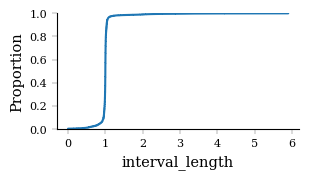

In [954]:
import matplotlib
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize' : [1.0*3.125, 1.5*1.0],
                           'legend.fontsize': 10, 'legend.fancybox': True,
                           'font.family': 'serif', 'font.sans-serif': 'Times',
                            'xtick.major.width': 0.2, 'xtick.minor.width': 2*0.2,
                            'ytick.major.width': 0.2, 'ytick.minor.width': 2*0.2,
                            'text.usetex': False, 'axes.labelsize': 7*1.5,
                            'axes.spines.right': False, 'axes.spines.top': False
                           })
sns.ecdfplot(data=dfi, x = 'interval_length')

In [955]:
data = []
for i in range(6):
    dfis = dfi[(dfi['interval_length'] >= i) & (dfi['interval_length'] < i+1)]
    dfis['Sampling Interval'] = f'[{i}, {i+1})'
    data.append(dfis)
dfi = pd.concat(data, axis=0)
dfi

,interval_length,ts,Prediction,Ground Truth,csv_file,VCA,Deviation,Sampling Interval
0,0.99,1684196880,12.65,8.04,/home/taveesh/Documents/Projects/vca-qoe-infer...,Webex,4.61,"[0, 1)"
2,1.00,1684196882,10.72,7.71,/home/taveesh/Documents/Projects/vca-qoe-infer...,Webex,3.01,"[0, 1)"
4,0.97,1684196884,13.40,8.40,/home/taveesh/Documents/Projects/vca-qoe-infer...,Webex,5.00,"[0, 1)"
7,0.99,1684196887,7.22,7.92,/home/taveesh/Documents/Projects/vca-qoe-infer...,Webex,0.70,"[0, 1)"
9,0.96,1684196889,13.23,8.66,/home/taveesh/Documents/Projects/vca-qoe-infer...,Webex,4.56,"[0, 1)"
...,...,...,...,...,...,...,...,...
20754,5.01,1684306561,32.48,0.00,/home/taveesh/Documents/Projects/vca-qoe-infer...,Meet,32.48,"[5, 6)"
21017,5.80,1684284226,125.33,118.00,/home/taveesh/Documents/Projects/vca-qoe-infer...,Meet,7.33,"[5, 6)"
21463,5.17,1684294290,1608.77,1226.78,/home/taveesh/Documents/Projects/vca-qoe-infer...,Meet,381.99,"[5, 6)"
25490,5.00,1684266473,438.97,44.41,/home/taveesh/Documents/Projects/vca-qoe-infer...,Teams,394.55,"[5, 6)"


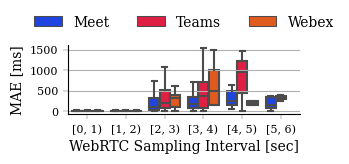

In [1076]:
dfi['VCA'] = dfi['VCA'].replace({'meet': 'Meet', 'teams': 'Teams', 'webex': 'Webex'})
sns.boxplot(data = dfi, x = 'Sampling Interval', y = 'Deviation', hue='VCA', showfliers=False, hue_order=['Meet', 'Teams', 'Webex'], palette={"Meet": colors[-1], "Teams": colors[7], "Webex": colors[9]})
# plt.ylim([-1000, 2700])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
plt.ylabel('MAE [ms]')
plt.xlabel('WebRTC Sampling Interval [sec]')
plt.gca().yaxis.grid(True)
plt.yticks([0, 500, 1000, 1500])
plt.savefig('paper_plots/frame_jitter_sampling_interval_imc_lab.pdf', bbox_inches='tight')

In [759]:
dfi[dfi['VCA'] == 'Meet']['Deviation'].mean()

33.038016380633714

In [762]:
x = df[(df['metric'] == 'frame_jitter')& (df['method'] == 'IP/UDP Heuristic')]

<Axes: xlabel='VCA', ylabel='abs_deviation'>

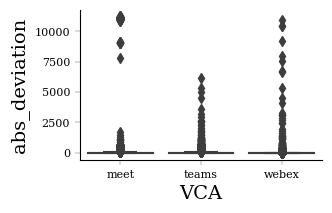

In [769]:
sns.boxplot(data=x, y = 'abs_deviation', x='VCA')
# plt.xlim([0, 100])

In [859]:
g = df[(df['metric'] == 'frame_jitter')& (df['method'] == 'IP/UDP Heuristic') & (df['VCA'] == 'meet') & (df['abs_deviation'] > 8000)]['csv_file'].tolist()
tsd = {}
tmin = {}
for csv_file in g:
    c = df[(df['metric'] == 'frame_jitter')& (df['method'] == 'IP/UDP Heuristic') & (df['VCA'] == 'meet') & (df['csv_file'] == csv_file)]
    tsd[csv_file] = list(c[c['abs_deviation'] > 7500]['timestamp'].unique())[0]
    tmin[csv_file] = df[(df['metric'] == 'frame_jitter')& (df['method'] == 'IP/UDP Heuristic') & (df['VCA'] == 'meet') & (df['csv_file'] == csv_file)]['timestamp'].min()

In [863]:
count = 0
rt = []
data = []
trel = []
for i in range(len(g)):    
    t = pd.read_csv(g[i], header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii')
    t_ = t[(t['frame.time_epoch'] >= tsd[g[i]]-1) & (t['frame.time_epoch'] < tsd[g[i]])]
    data.append(t_)
    times = t[(t['frame.time_epoch'] >= tsd[g[i]]-1) & (t['frame.time_epoch'] < tsd[g[i]])]['frame.time_epoch'].tolist()
    times = [x - tmin[g[i]] for x in times]
    trel += times

In [868]:
df = pd.read_csv(g[0], header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii')
dfg = df.groupby('rtp.timestamp').agg(max_size=('udp.length', max), min_size = ('udp.length', min)).reset_index()
if df['ip.proto'].dtype == object:
    df = df[df['ip.proto'].str.contains(',') == False]
df = df[~df['ip.proto'].isna()]
df['ip.proto'] = df['ip.proto'].astype(int)
df = df[(df['ip.proto'] == 17) & (df['ip.dst'] == '192.168.1.187')]
src = df.groupby('ip.src').agg({'udp.length': sum, 'rtp.p_type': 'count'}).reset_index().sort_values(by='udp.length', ascending=False).head(1)['ip.src'].iloc[0]
df = df[df['ip.src'] == src]

df = df[df['udp.length'] > 306]
df = df.sort_values(by=['frame.time_relative'])
frame_id_assignment = [-1 for _ in range(df.shape[0])]
frame_id = 1
l = 2
for i in range(df.shape[0]):
    found = False
    s = df.iloc[i]['udp.length']
    for j in range(i-1, max(0, i-l-1), -1):
        if abs(df.iloc[j]['udp.length'] - s) <= 2:
            frame_id_assignment[i] = frame_id
            found = True
            break
    if not found:
        frame_id += 1
        frame_id_assignment[i] = frame_id
df["frame_num"] = frame_id_assignment

In [869]:
df.head(20)

,frame.time_relative,frame.time_epoch,ip.src,ip.dst,ip.proto,ip.len,udp.srcport,udp.dstport,udp.length,rtp.ssrc,rtp.timestamp,rtp.seq,rtp.p_type,rtp.marker,frame_num
1036,8.28,1684301395.29,142.250.82.185,192.168.1.187,17,1231,3478.00,53804.00,1211.00,NaN,nan,nan,NaN,nan,2
1041,8.33,1684301395.33,142.250.82.185,192.168.1.187,17,598,3478.00,53804.00,578.00,NaN,nan,nan,NaN,nan,3
1315,24.10,1684301411.10,142.250.82.185,192.168.1.187,17,1253,3478.00,53804.00,1233.00,NaN,nan,nan,NaN,nan,4
1369,24.15,1684301411.16,142.250.82.185,192.168.1.187,17,337,3478.00,53804.00,317.00,NaN,nan,nan,NaN,nan,5
1470,25.18,1684301412.18,142.250.82.185,192.168.1.187,17,981,3478.00,53804.00,961.00,0x7da5a8c5,2042137742.00,0.00,98,0.00,6
1471,25.19,1684301412.20,142.250.82.185,192.168.1.187,17,994,3478.00,53804.00,974.00,0x7da5a8c5,2042137742.00,1.00,98,0.00,7
1472,25.21,1684301412.22,142.250.82.185,192.168.1.187,17,994,3478.00,53804.00,974.00,0x7da5a8c5,2042137742.00,2.00,98,0.00,7
1474,25.23,1684301412.24,142.250.82.185,192.168.1.187,17,990,3478.00,53804.00,970.00,0x7da5a8c5,2042137742.00,3.00,98,1.00,8
1475,25.25,1684301412.26,142.250.82.185,192.168.1.187,17,455,3478.00,53804.00,435.00,0x7da5a8c5,2042141522.00,4.00,98,1.00,9
1477,25.26,1684301412.27,142.250.82.185,192.168.1.187,17,568,3478.00,53804.00,548.00,0x7da5a8c5,2042144762.00,5.00,98,1.00,10


In [807]:
t[(t['frame.time_epoch'] >= tsd[g[0]]) & (t['frame.time_epoch'] < tsd[g[0]] + 1)]

,frame.time_relative,frame.time_epoch,ip.src,ip.dst,ip.proto,ip.len,udp.srcport,udp.dstport,udp.length,rtp.ssrc,rtp.timestamp,rtp.seq,rtp.p_type,rtp.marker
1465,25.01,1684301412.02,192.168.1.187,142.250.82.185,17,93,53804.00,3478.00,73.00,NaN,nan,nan,NaN,nan
1466,25.01,1684301412.02,192.168.1.187,142.250.82.185,17,381,53804.00,3478.00,361.00,NaN,nan,nan,NaN,nan
1467,25.03,1684301412.03,192.168.1.187,142.250.82.185,17,88,53804.00,3478.00,68.00,NaN,nan,nan,NaN,nan
1468,25.06,1684301412.07,142.250.82.185,192.168.1.187,17,277,3478.00,53804.00,257.00,NaN,nan,nan,NaN,nan
1469,25.14,1684301412.14,192.168.1.187,142.250.82.185,17,92,53804.00,3478.00,72.00,NaN,nan,nan,NaN,nan
1470,25.18,1684301412.18,142.250.82.185,192.168.1.187,17,981,3478.00,53804.00,961.00,0x7da5a8c5,2042137742.00,0.00,98,0.00
1471,25.19,1684301412.20,142.250.82.185,192.168.1.187,17,994,3478.00,53804.00,974.00,0x7da5a8c5,2042137742.00,1.00,98,0.00
1472,25.21,1684301412.22,142.250.82.185,192.168.1.187,17,994,3478.00,53804.00,974.00,0x7da5a8c5,2042137742.00,2.00,98,0.00
1473,25.23,1684301412.24,192.168.1.187,142.250.82.185,17,76,53804.00,3478.00,56.00,NaN,nan,nan,NaN,nan
1474,25.23,1684301412.24,142.250.82.185,192.168.1.187,17,990,3478.00,53804.00,970.00,0x7da5a8c5,2042137742.00,3.00,98,1.00


In [797]:
df[(df['metric'] == 'frame_jitter')& (df['method'] == 'IP/UDP Heuristic') & (df['csv_file'] == '/home/taveesh/Documents/Projects/vca-qoe-inference/data/IMC_Lab_data/2023-05-16_meet_5522_2415_29_2_0_43_226/meet/captures/meet-chrome-5522_2415_29_2_0_43_226-1684301386.csv')]

,Prediction,Ground Truth,timestamp,pcap_file,cross_val,metric,method,VCA,deviation,abs_deviation,ts,ssrc,lastPacketReceivedTimestamp,framesPerSecond,bitrate,[codec],packetsLost,framesDropped,framesReceived,framesReceivedPerSecond,frame_jitter,nackCount,packetsReceived,trackIdentifier,freezeCount,totalFreezesDuration,pauseCount,totalPausesDuration,jitterBufferDelay,framesDecodedPerSecond,jitterBufferEmittedCount,frameHeight,qpSum,duration,num_vals,csv_file,webrtc_file
485936,11115.15,0.00,1684301412,/home/taveesh/Documents/Projects/vca-qoe-infer...,1,frame_jitter,IP/UDP Heuristic,meet,11115.15,11115.15,1684301412,2108008645,1684301412297.00,54.00,0.00,"VP9 (98, profile-id=0)",0,0,4,0.00,0.00,0,7,cc9c5446-1cee-40a9-be9d-178c73ebfb19,0,0.00,0,0,0.06,0.00,3,180.00,694.00,37.58,38,/home/taveesh/Documents/Projects/vca-qoe-infer...,/home/taveesh/Documents/Projects/vca-qoe-infer...
485937,203.26,12.87,1684301413,/home/taveesh/Documents/Projects/vca-qoe-infer...,1,frame_jitter,IP/UDP Heuristic,meet,190.38,190.38,1684301413,2108008645,1684301413309.00,24.00,122788.72,"VP9 (98, profile-id=0)",0,0,25,24.99,12.87,0,37,cc9c5446-1cee-40a9-be9d-178c73ebfb19,0,0.00,0,0,0.72,23.99,25,180.00,4505.00,37.58,38,/home/taveesh/Documents/Projects/vca-qoe-infer...,/home/taveesh/Documents/Projects/vca-qoe-infer...
485938,14.81,12.29,1684301414,/home/taveesh/Documents/Projects/vca-qoe-infer...,1,frame_jitter,IP/UDP Heuristic,meet,2.52,2.52,1684301414,2108008645,1684301414287.00,24.00,102027.99,"VP9 (98, profile-id=0)",0,0,24,24.00,12.29,0,63,cc9c5446-1cee-40a9-be9d-178c73ebfb19,0,0.00,0,0,0.71,25.00,24,180.00,4750.00,37.58,38,/home/taveesh/Documents/Projects/vca-qoe-infer...,/home/taveesh/Documents/Projects/vca-qoe-infer...
485939,14.66,11.29,1684301415,/home/taveesh/Documents/Projects/vca-qoe-infer...,1,frame_jitter,IP/UDP Heuristic,meet,3.37,3.37,1684301415,2108008645,1684301415277.00,25.00,120152.52,"VP9 (98, profile-id=0)",0,0,25,25.00,11.29,0,93,cc9c5446-1cee-40a9-be9d-178c73ebfb19,0,0.00,0,0,0.78,25.00,25,180.00,4665.00,37.58,38,/home/taveesh/Documents/Projects/vca-qoe-infer...,/home/taveesh/Documents/Projects/vca-qoe-infer...
485940,16.27,7.84,1684301416,/home/taveesh/Documents/Projects/vca-qoe-infer...,1,frame_jitter,IP/UDP Heuristic,meet,8.43,8.43,1684301416,2108008645,1684301416284.00,25.00,125572.57,"VP9 (98, profile-id=0)",0,0,25,24.98,7.84,0,123,cc9c5446-1cee-40a9-be9d-178c73ebfb19,0,0.00,0,0,0.77,24.98,25,180.00,4522.00,37.58,38,/home/taveesh/Documents/Projects/vca-qoe-infer...,/home/taveesh/Documents/Projects/vca-qoe-infer...
485941,12.92,8.24,1684301417,/home/taveesh/Documents/Projects/vca-qoe-infer...,1,frame_jitter,IP/UDP Heuristic,meet,4.68,4.68,1684301417,2108008645,1684301417279.00,25.00,148652.12,"VP9 (98, profile-id=0)",0,0,25,25.01,8.24,0,153,cc9c5446-1cee-40a9-be9d-178c73ebfb19,0,0.00,0,0,0.77,25.01,25,180.00,4436.00,37.58,38,/home/taveesh/Documents/Projects/vca-qoe-infer...,/home/taveesh/Documents/Projects/vca-qoe-infer...
485942,16.69,7.82,1684301418,/home/taveesh/Documents/Projects/vca-qoe-infer...,1,frame_jitter,IP/UDP Heuristic,meet,8.87,8.87,1684301418,2108008645,1684301418296.00,25.00,144408.95,"VP9 (98, profile-id=0)",0,0,25,25.00,7.82,0,185,cc9c5446-1cee-40a9-be9d-178c73ebfb19,0,0.00,0,0,0.78,25.00,25,180.00,4584.00,37.58,38,/home/taveesh/Documents/Projects/vca-qoe-infer...,/home/taveesh/Documents/Projects/vca-qoe-infer...
485943,12.73,8.28,1684301419,/home/taveesh/Documents/Projects/vca-qoe-infer...,1,frame_jitter,IP/UDP Heuristic,meet,4.45,4.45,1684301419,2108008645,1684301419280.00,25.00,131806.50,"VP9 (98, profile-id=0)",0,0,25,25.01,8.28,0,216,cc9c5446-1cee-40a9-be9d-178c73ebfb19,0,0.00,0,0,0.77,25.01,25,180.00,4524.00,37.58,38,/home/taveesh/Documents/Projects/vca-qoe-infer...,/home/taveesh/Documents/Projects/vca-qoe-infer...
485944,15.25,9.03,1684301420,/home/taveesh/Documents/Projects/vca-qoe-infer...,1,frame_jitter,IP/UDP Heuristic,meet,6.22,6.22,1684301420,2108008645,1684301420285.00,25.00,136206.62,"VP9 (98, pr

In [1140]:
ip = [[1.55,1.3,1.33, 1],[1.14,0.89,1.1, 2],[1.01,0.77,1.02, 3],[0.96,0.73,0.98, 4],[0.96,0.66,0.97, 5],[0.86,0.66,0.91, 6],[0.86,0.63,0.84, 7],[0.8,0.62,0.87, 8],[0.84,0.64,0.79, 9],[0.84,0.65,0.82, 10]]
rtp = [[1.56,1.19,1.24, 1],[1.1,0.89,1.02, 2],[0.87,0.68,0.87, 3],[0.85,0.63,0.81, 4],[0.75,0.57,0.77, 5],[0.64,0.55,0.77, 6],[0.66,0.54,0.72, 7],[0.6,0.52,0.67, 8],[0.6,0.46,0.62, 9],[0.58,0.52,0.65, 10]]

In [1141]:
ip_ = []
for arr in ip:
    arr[0], arr[1] = arr[1], arr[0]
    ip_.append(arr)
ip = pd.DataFrame(ip_, columns=['Meet', 'Teams', 'Webex', 'Prediction Window Size'])
rtp = pd.DataFrame(rtp, columns=['Meet', 'Teams', 'Webex', 'Prediction Window Size'])

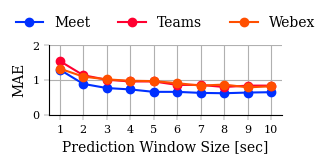

In [1142]:
ip.plot(x = 'Prediction Window Size', marker='o', color=c)
c = {'Meet': colors[-1], 'Teams': colors[7], 'Webex': colors[9]}
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False, labels=['Meet', 'Teams', 'Webex'])
plt.grid()
plt.ylabel('MAE')
plt.xlabel('Prediction Window Size [sec]')
plt.xticks(list(range(1, 11)))
plt.ylim([0, 2])
plt.savefig('paper_plots/window_size_ip_ml.pdf', bbox_inches='tight')